In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense, TimeDistributed
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import keras.backend as K
from keras.losses import categorical_crossentropy

# Chargement des données
data = pd.read_csv('turnips2.csv')

# Sélection des colonnes pertinentes (prix)
columns = ['Mon-AM', 'Mon-PM', 'Tues-AM', 'Tues-PM', 'Wed-AM', 'Wed-PM', 'Thurs-AM', 'Thurs-PM', 'Fri-AM', 'Fri-PM', 'Sat-AM', 'Sat-PM']

# Normalisation des données
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[columns])

# Clustering pour déterminer les labels
kmeans = KMeans(n_clusters=4, random_state=0)
labels = kmeans.fit_predict(data_scaled)

# Préparation des données pour le RNN
X = np.reshape(data_scaled, (data_scaled.shape[0], 12, 1))  # Remodelage en [échantillons, pas de temps, caractéristiques]
y = to_categorical(labels)  # Conversion des labels en format catégorique pour la classification

# Extension des étiquettes pour chaque pas de temps dans la séquence
y_expanded = np.repeat(y[:, np.newaxis, :], 12, axis=1)

# Split des données en ensembles d'entraînement et de test avec les étiquettes ajustées
X_train, X_test, y_train, y_test = train_test_split(X, y_expanded, test_size=0.2, random_state=42)

# Nombre de classes pour la classification
num_classes = 4  # Ajustez ce nombre en fonction de votre nombre de classes réel


def weighted_loss(a):
    def loss(y_true, y_pred):
        # Calcul de la perte catégorique croisée standard
        standard_loss = categorical_crossentropy(y_true, y_pred)
        
        # Calcul des poids pour chaque pas de temps dans la séquence
        # K.arange génère une séquence de 0 à nb_steps-1, où nb_steps est la taille de la séquence
        nb_steps = K.int_shape(y_pred)[1]
        timesteps = K.arange(nb_steps, dtype=K.floatx())
        weights = (a*timesteps)**2#1 - K.exp(-a * timesteps)  # 1-exp(-at) pour chaque pas de temps
        
        # Appliquer les poids à la perte
        weighted_loss = weights * standard_loss
        
        # Moyenne sur tous les pas de temps
        return K.mean(weighted_loss, axis=-1)
    
    return loss

def create_rnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(GRU(units=20, return_sequences=True, input_shape=input_shape))
    # Utilisez TimeDistributed pour appliquer une couche Dense à chaque sortie de séquence
    model.add(TimeDistributed(Dense(num_classes, activation='softmax')))
    model.compile(optimizer='adam', loss=weighted_loss(a=0.1), metrics=['accuracy'])
    return model

# Créez le modèle en spécifiant la forme d'entrée et le nombre de classes
model = create_rnn_model(input_shape=(12, 1), num_classes=num_classes)

# Entraînement du modèle
model.fit(X_train, y_train, epochs=1000, batch_size=256, verbose=1)

# Évaluation du modèle
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/1000
32/32 [==============================] - 1s 7ms/step - loss: 0.5675 - accuracy: 0.3511
Epoch 2/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.5275 - accuracy: 0.3453
Epoch 3/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.4743 - accuracy: 0.3591
Epoch 4/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.4022 - accuracy: 0.4023
Epoch 5/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.3558 - accuracy: 0.4151
Epoch 6/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.3263 - accuracy: 0.4321
Epoch 7/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.3038 - accuracy: 0.4539
Epoch 8/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.2849 - accuracy: 0.4745
Epoch 9/1000
32/32 [==============================] - 0s 4ms/step - loss: 0.2677 - accuracy: 0.4931
Epoch 10/1000
32/32 [==============================] - 0s 4ms/step - loss: 0.2515 - accuracy: 0.5132

1/1 [==============================] - 0s 17ms/step


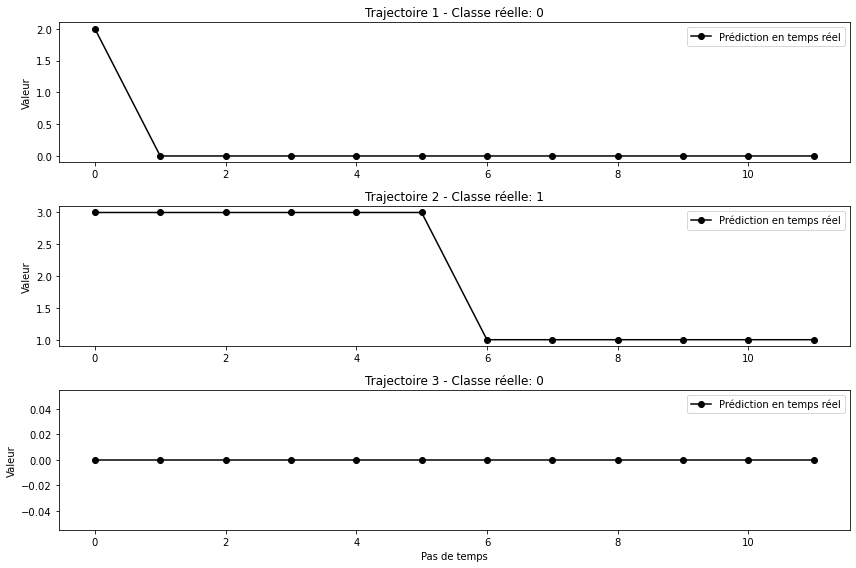

In [47]:
import matplotlib.pyplot as plt

# Sélection aléatoire de 3 indices d'échantillons dans l'ensemble de test
indices = np.random.choice(range(len(X_test)), 3, replace=False)

# Configuration des couleurs pour les graphiques
colors = ['red', 'green', 'blue']

plt.figure(figsize=(12, 8))

for i, idx in enumerate(indices):
    # Extraction de l'échantillon et de son étiquette réelle
    sample, true_label = X_test[idx], y_test[idx]
    sample = sample.reshape(1, 12, 1)  # Redimensionnement pour correspondre à l'entrée attendue du modèle
    true_label = np.argmax(true_label, axis=1)[0]
    # Prédiction avec le modèle RNN
    prediction = model.predict(sample)
    predicted_label = np.argmax(prediction, axis=2).reshape(12,)
    # Tracé de la trajectoire réelle
    plt.subplot(3, 1, i+1)
    plt.plot(predicted_label, label='Prédiction en temps réel', color='black', marker='o')
    plt.plot(true_label*np.ones(12), label='Label réel', color='red', marker='x')
    
    # Ajout du titre incluant la classe prédite
    plt.title(f'Trajectoire {i+1} - Classe réelle: {true_label}')
    plt.ylabel('Valeur')
    plt.legend()

plt.xlabel('Pas de temps')
plt.tight_layout()
plt.show()